In [1]:
#Imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import statsmodels.api as sm 
from statsmodels.graphics.api import abline_plot 
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import train_test_split 
from sklearn import linear_model, preprocessing 
import warnings 

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [2]:
ls

 Volume in drive C has no label.
 Volume Serial Number is 9806-1F72

 Directory of C:\Users\Armstrongs\Desktop\GitHub\employees_india

11/26/2021  04:27 PM    <DIR>          .
11/26/2021  04:27 PM    <DIR>          ..
11/26/2021  02:32 PM    <DIR>          .ipynb_checkpoints
11/23/2021  02:50 PM           195,247 Employee.csv
11/26/2021  04:27 PM           277,933 Employees EDA.ipynb
11/23/2021  10:13 PM                 5 IND_adm1.cpg
11/23/2021  10:13 PM             3,539 IND_adm1.csv
11/23/2021  10:13 PM            28,279 IND_adm1.dbf
11/23/2021  10:13 PM               145 IND_adm1.prj
11/23/2021  10:13 PM            23,375 IND_adm1.shp.xml
11/23/2021  10:13 PM               396 IND_adm1.shx
11/23/2021  10:13 PM         8,450,224 IND_adm11.shp
11/23/2021  10:13 PM             5,870 IND_adm1-fgdc.xml
11/23/2021  10:13 PM            11,935 IND_adm1-iso19110.xml
11/23/2021  10:13 PM            21,893 IND_adm1-iso19139.xml
11/26/2021  02:36 PM               128 sns_test.csv
11/26/2021  0

In [3]:
#importing data
df = pd.read_csv('Employee.csv')
df.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


In [4]:
df.shape

(4653, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Education                  4653 non-null   object
 1   JoiningYear                4653 non-null   int64 
 2   City                       4653 non-null   object
 3   PaymentTier                4653 non-null   int64 
 4   Age                        4653 non-null   int64 
 5   Gender                     4653 non-null   object
 6   EverBenched                4653 non-null   object
 7   ExperienceInCurrentDomain  4653 non-null   int64 
 8   LeaveOrNot                 4653 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 327.3+ KB


In [6]:
df['Education'].value_counts()

Bachelors    3601
Masters       873
PHD           179
Name: Education, dtype: int64

In [7]:
#let's see which gender quits more often:
#First making sure the labels are clean
df.Gender.value_counts()

Male      2778
Female    1875
Name: Gender, dtype: int64

In [8]:
male = df[df['Gender'] == 'Male']
malequit = male['LeaveOrNot'].sum()
female = df[df['Gender'] == 'Female']
femalequit = female['LeaveOrNot'].sum()
totalquit = df['LeaveOrNot'].sum()
print("male ratio: " + str(malequit/totalquit) + " female ratio: " + str(femalequit/totalquit))
#It looks like females quit at a slightly higher rate

male ratio: 0.4475 female ratio: 0.5525


In [9]:
#Hold on. I think I've done my math incorrectly. The above would only work if there were an equal number of males and females.
#Let me examine the actual ratio of males and females that quit in relation to the total of their own gender.
#It seems females quit at a MUCH higher rate than males.
print("male ratio: " + str(malequit/len(male)) + " female ratio: " + str(femalequit/len(female)))

male ratio: 0.257739380849532 female ratio: 0.47146666666666665


In [10]:
#Could have just used the .mean() function. 
male['LeaveOrNot'].mean()

0.257739380849532

In [11]:
nopune = df[df['City'] != "Pune"]
npfemale = nopune[nopune['Gender'] == 'Female']
npfemale['LeaveOrNot'].mean()

0.30727130570758404

In [12]:
#Why are females quiting so much? Are they getting paid less? Are they younger? 
female['PaymentTier'].mean()

2.5376

In [13]:
male['PaymentTier'].mean()

2.806695464362851

<AxesSubplot:xlabel='Gender', ylabel='PaymentTier'>

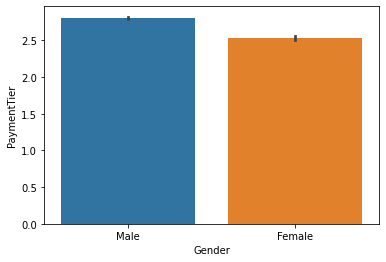

In [14]:
sns.barplot(x='Gender', y = 'PaymentTier', data = df)

<AxesSubplot:xlabel='City', ylabel='PaymentTier'>

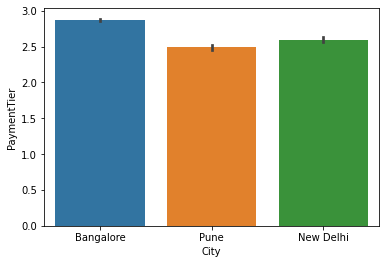

In [15]:
sns.barplot(x='City', y = 'PaymentTier', data = df)

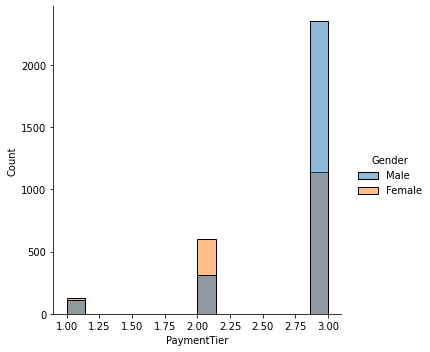

In [16]:
sns.displot(data=df, x="PaymentTier", hue="Gender")

In [17]:
female['Age'].mean()

29.416

In [18]:
male['Age'].mean()

29.377969762419006

In [19]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""
 
    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))
 
    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)
 
    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]
 
    return perm_sample_1, perm_sample_2

In [20]:
#Could it be that males and females quit at a similar rate? 
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""
 
    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)
 
    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)
 
        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)
 
    return perm_replicates

In [21]:
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""
 
    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1) - np.mean(data_2)
 
    return diff
 
# Compute difference of mean impact force from experiment: empirical_diff_means
empirical_diff_means = diff_of_means(male['LeaveOrNot'], female['LeaveOrNot'])
 
# Draw 10,000 permutation replicates: perm_replicates
perm_replicates = draw_perm_reps(male['LeaveOrNot'], female['LeaveOrNot'],
                                 diff_of_means, size=10000)
 
# Compute p-value: p
p = np.sum(perm_replicates <= empirical_diff_means) / len(perm_replicates)
 
# Print the result
print('p-value =', p)


p-value = 0.0


In [22]:
empirical_diff_means

-0.21372728581713463

In [23]:
male['LeaveOrNot'].mean() - female['LeaveOrNot'].mean()

-0.21372728581713463

In [24]:
perm_replicates

array([-0.01720029,  0.00602563, -0.03059986, ...,  0.00691893,
        0.00691893,  0.02567833])

In [25]:
sum(perm_replicates < -0.01)

2503

In [26]:
#Let's see how experience interacts with quitting:
df['ExperienceInCurrentDomain'].value_counts()

2    1087
4     931
5     919
3     786
1     558
0     355
7       9
6       8
Name: ExperienceInCurrentDomain, dtype: int64

<AxesSubplot:xlabel='Education', ylabel='count'>

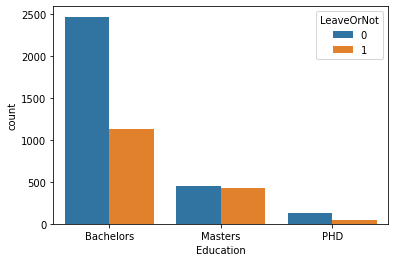

In [27]:
sns.countplot(data=df, x='Education', hue='LeaveOrNot')

<AxesSubplot:xlabel='Education', ylabel='count'>

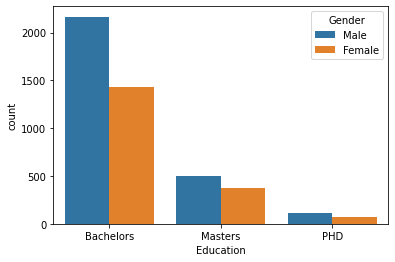

In [28]:
sns.countplot(data=df, x='Education', hue='Gender')

In [29]:
sum(male['Education'] == 'Masters') / len(male)

0.18070554355651547

In [30]:
sum(female['Education'] == 'Masters') / len(female)

0.19786666666666666

In [31]:
sum(female['Education'] == 'Masters') / len(df)

0.07973350526542015

In [32]:
sum(male['Education'] == 'Masters') / len(df)

0.10788738448312916

In [33]:
sum(df['Education'] == 'Masters') / len(df)

0.18762088974854932

In [34]:
#That's actually not too bad of a range. I don't think i'll have to bin them, but I will anyway for expedience. 
df['experiencelevel'] = pd.cut(df['ExperienceInCurrentDomain'], bins=[0, 2, 5, float('Inf')], labels=['low', 'mod', 'high'])
lowexp = df[df['experiencelevel'] == 'low']
lowquit = lowexp['LeaveOrNot'].sum()
modexp = df[df['experiencelevel'] == 'mod']
modquit = modexp['LeaveOrNot'].sum()
highexp = df[df['experiencelevel'] == 'high']
highquit = highexp['LeaveOrNot'].sum()
print("low ratio: " + str(lowquit/len(lowexp)) + " mod ratio: " + str(modquit/len(modexp)) + " high ratio: " + str(highquit/len(highexp)))

low ratio: 0.356838905775076 mod ratio: 0.3353566009104704 high ratio: 0.29411764705882354


In [35]:
len(df[df['ExperienceInCurrentDomain'] > 5])

17

In [36]:
df['ExperienceInCurrentDomain'].value_counts()

2    1087
4     931
5     919
3     786
1     558
0     355
7       9
6       8
Name: ExperienceInCurrentDomain, dtype: int64

In [37]:
#It seems like people with the lowest amount of experience quit at the highest rate, but it is pretty evenly distributed 
#throughout. Taking a look at payment tiers now.
df['PaymentTier'].value_counts()

3    3492
2     918
1     243
Name: PaymentTier, dtype: int64

<BarContainer object of 4653 artists>

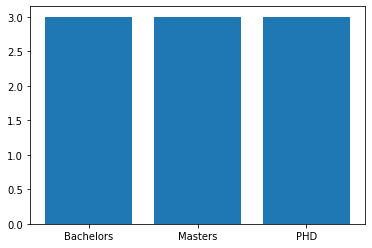

In [38]:
#It looks like 3 is the most common tier. I'm going to assume that it's the lowest. Let's take a look at how education
#and experience factor into pay. 
fig, ax = plt.subplots()
ax.bar(df.Education,df['PaymentTier'])

In [39]:
#That doesn't seem correct. Maybe I've made a mistake. 
bach = df[df['Education'] == 'Bachelors']
bach['PaymentTier'].value_counts()

3    2885
2     543
1     173
Name: PaymentTier, dtype: int64

In [40]:
mas = df[df['Education'] == 'Masters']
mas['PaymentTier'].value_counts()

3    462
2    355
1     56
Name: PaymentTier, dtype: int64

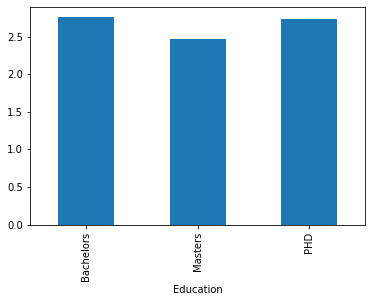

In [41]:
nb_sold_by_size = df.groupby('Education')['PaymentTier'].mean()
nb_sold_by_size.plot(kind='bar')
plt.show()

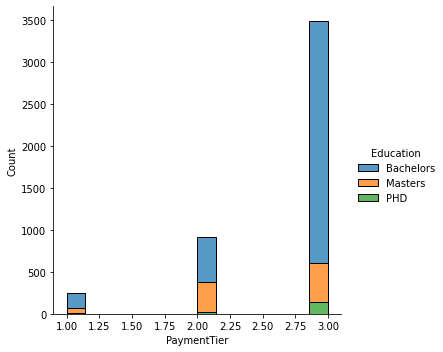

In [42]:
sns.displot(data=df, x="PaymentTier", hue="Education", multiple="stack")

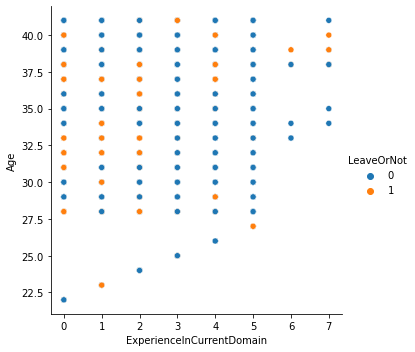

In [43]:
sns.relplot(x="ExperienceInCurrentDomain", y="Age", 
            data=df, kind="scatter", hue='LeaveOrNot')
 
# Show plot
plt.show()

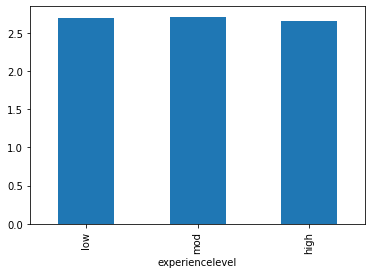

In [44]:
#So it looks like education does not have too much of a role in payment tears as the proportions of each degree seem consistent
nb_sold_by_size = df.groupby('experiencelevel')['PaymentTier'].mean()
nb_sold_by_size.plot(kind='bar')
plt.show()

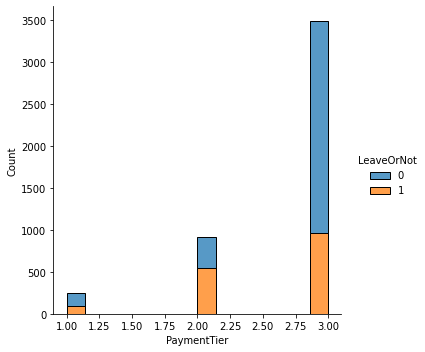

In [45]:
sns.displot(data=df, x="PaymentTier", hue="LeaveOrNot", multiple="stack")

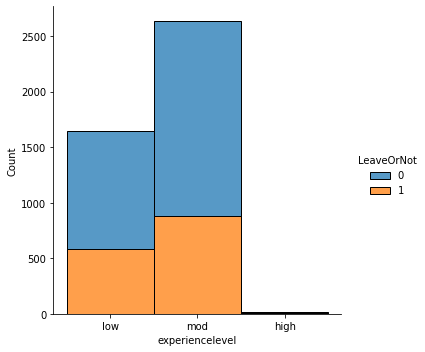

In [46]:
sns.displot(data=df, x="experiencelevel", hue="LeaveOrNot", multiple="stack")

In [47]:
#It looks like education level has a slight effect on payment tier but not in a way that I would expect. The same pattern
#Is present in experience level but the difference is negligable at best. 
#What about age? Lets bin it into groups and then see how it changes the target variable
df['agelevel'] = pd.cut(df['Age'], bins=[0, 25, 45, float('Inf')], labels=['young', 'mid', 'old'])
young = df[df['agelevel'] == 'young']
youngquit = young['LeaveOrNot'].sum()
mid = df[df['agelevel'] == 'mid']
midquit = mid['LeaveOrNot'].sum()
old = df[df['agelevel'] == 'old']
oldquit = old['LeaveOrNot'].sum()
print("young ratio: " + str(youngquit/totalquit) + " mod ratio: " + str(midquit/totalquit) + " high ratio: " + str(oldquit/totalquit))

young ratio: 0.2275 mod ratio: 0.7725 high ratio: 0.0


In [48]:
#This doesn't seem entirely correct. Do I really have no older people quitting? Let's examine the values. 
agevals = pd.DataFrame(df['Age'].value_counts())
agevals.sort_index()

,Age
22,49
23,48
24,385
25,418
26,645
27,625
28,630
29,230
30,220
31,125


In [49]:
#Oh. That explains it. Not a wide agerange of workers here. Let's change those bins up. 
#It looks like education level has a slight effect on payment tier but not in a way that I would expect. The same pattern
#Is present in experience level but the difference is negligable at best. 
#What about age? Lets bin it into groups and then see how it changes the target variable
df['agelevel'] = pd.cut(df['Age'], bins=[0, 28, 35, float('Inf')], labels=['young', 'mid', 'old'])
young = df[df['agelevel'] == 'young']
youngquit = young['LeaveOrNot'].sum()
mid = df[df['agelevel'] == 'mid']
midquit = mid['LeaveOrNot'].sum()
old = df[df['agelevel'] == 'old']
oldquit = old['LeaveOrNot'].sum()
print("young ratio: " + str(youngquit/len(young)) + " mod ratio: " + str(midquit/len(mid)) + " high ratio: " + str(oldquit/len(old)))

young ratio: 0.35678571428571426 mod ratio: 0.3394495412844037 high ratio: 0.30275229357798167


In [50]:
#Checking payment tiers
lowpay = df[df['PaymentTier'] == 3]
lowpayquit = lowpay['LeaveOrNot'].sum()
modpay = df[df['PaymentTier'] == 2]
modpayquit = modpay['LeaveOrNot'].sum()
highpay = df[df['PaymentTier'] == 3]
highpayquit = highexp['LeaveOrNot'].sum()
print("low ratio: " + str(lowpayquit/len(lowpay)) + " mod ratio: " + str(modpayquit/len(modpay)) + " high ratio: " + str(highpayquit/len(highpay)))

low ratio: 0.27520045819014893 mod ratio: 0.599128540305011 high ratio: 0.0014318442153493699


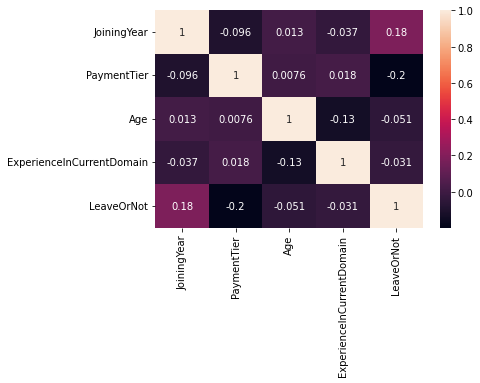

In [51]:
#It looks like people in the middle payment tier quit at a much higher rate than the other two with the highest not quitting. 
#Alright and finally let's make a heatmap to see how these features all correlate to the target
plt.figure()
sns.heatmap(df.corr(), annot=True)
plt.show()

In [52]:
#Some very weak correlations here. 


In [53]:
#pip install pyshp
import shapefile as shp

In [54]:
sns.set(style='whitegrid', palette='pastel', color_codes=True)
sns.mpl.rc('figure', figsize=(10,6))

In [55]:
ls

 Volume in drive C has no label.
 Volume Serial Number is 9806-1F72

 Directory of C:\Users\Armstrongs\Desktop\GitHub\employees_india

11/26/2021  04:27 PM    <DIR>          .
11/26/2021  04:27 PM    <DIR>          ..
11/26/2021  02:32 PM    <DIR>          .ipynb_checkpoints
11/23/2021  02:50 PM           195,247 Employee.csv
11/26/2021  04:27 PM           277,933 Employees EDA.ipynb
11/23/2021  10:13 PM                 5 IND_adm1.cpg
11/23/2021  10:13 PM             3,539 IND_adm1.csv
11/23/2021  10:13 PM            28,279 IND_adm1.dbf
11/23/2021  10:13 PM               145 IND_adm1.prj
11/23/2021  10:13 PM            23,375 IND_adm1.shp.xml
11/23/2021  10:13 PM               396 IND_adm1.shx
11/23/2021  10:13 PM         8,450,224 IND_adm11.shp
11/23/2021  10:13 PM             5,870 IND_adm1-fgdc.xml
11/23/2021  10:13 PM            11,935 IND_adm1-iso19110.xml
11/23/2021  10:13 PM            21,893 IND_adm1-iso19139.xml
11/26/2021  02:36 PM               128 sns_test.csv
11/26/2021  0

In [56]:
#opening the vector map
shp_path = 'IND_adm11.shp'
#reading the shape file by using reader function of the shape lib
sf = shp.Reader(shp_path)

In [57]:
len(sf.shapes())

37

In [58]:
def read_shapefile(sf):
    #fetching the headings from the shape file
    fields = [x[0] for x in sf.fields][1:]
#fetching the records from the shape file
    records = [list(i) for i in sf.records()]
    shps = [s.points for s in sf.shapes()]
#converting shapefile data into pandas dataframe
    dfs = pd.DataFrame(columns=fields, data=records)
#assigning the coordinates
    dfs = df.assign(coords=shps)
    return dfs

In [59]:
df = read_shapefile(sf)
df.shape

ShapefileException: Shapefile Reader requires a shapefile or file-like object. (no dbf file found)

In [ ]:
#I wanted to map out where people were quiting but it's not working as I'd hoped. 

In [ ]:
#I want to know whether women really are more likely to quit or if it's really due to location
df['City'].value_counts()

In [ ]:
b = df[df['City'] == 'Bangalore']
len(b[b['Gender'] == 'Male'])

In [ ]:
len(b[b['Gender'] == 'Female'])

In [ ]:
B = df[df["City"] == "Bangalore"]["LeaveOrNot"].sum()
P = df[df["City"] == "Pune"]["LeaveOrNot"].sum()
D = df[df["City"] == "New Delhi"]["LeaveOrNot"].sum()

In [ ]:
FB = female[female["City"] == "Bangalore"]["LeaveOrNot"].sum()
FP = female[female["City"] == "Pune"]["LeaveOrNot"].sum()
FD = female[female["City"] == "New Delhi"]["LeaveOrNot"].sum()

In [ ]:
MB = male[male["City"] == "Bangalore"]["LeaveOrNot"].sum()
MP = male[male["City"] == "Pune"]["LeaveOrNot"].sum()
MD = male[male["City"] == "New Delhi"]["LeaveOrNot"].sum()

In [ ]:
print('B: ' + str(FB / len(female['City'] == 'Bangalore')))

In [ ]:
print('P: ' + str(FP / len(female['City'] == 'Pune')))

In [ ]:
print('D: ' + str(FD / len(female['City'] == 'New Delhi')))

In [ ]:
city_order = ['Bangalore', 'Pune', 'New Delhi']

In [ ]:
sns.countplot(data=female, x='City', hue='LeaveOrNot', order = city_order)

In [ ]:
sns.countplot(data=male, x='City', hue='LeaveOrNot')

In [ ]:
sns.countplot(data=df, x='City', hue='LeaveOrNot')

(array([ 39., 327., 497., 367., 127.,  95., 106., 120., 114.,  83.]),
 array([22. , 23.9, 25.8, 27.7, 29.6, 31.5, 33.4, 35.3, 37.2, 39.1, 41. ]),
 <BarContainer object of 10 artists>)

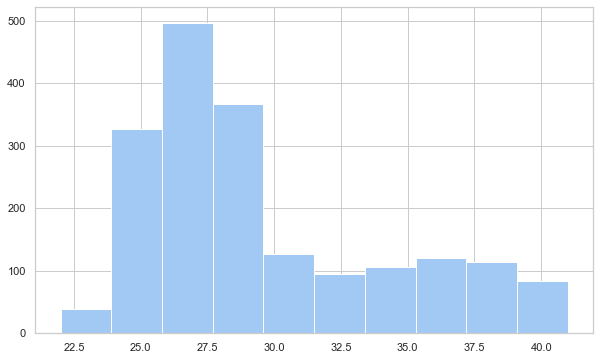

In [60]:
plt.hist(female['Age'])

<AxesSubplot:xlabel='Age', ylabel='count'>

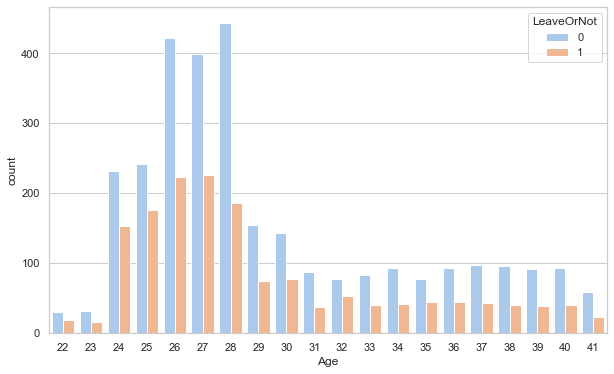

In [62]:
sns.countplot(data=df, x='Age', hue='LeaveOrNot')

(array([ 58., 476., 773., 493., 218., 161., 153., 160., 153., 133.]),
 array([22. , 23.9, 25.8, 27.7, 29.6, 31.5, 33.4, 35.3, 37.2, 39.1, 41. ]),
 <BarContainer object of 10 artists>)

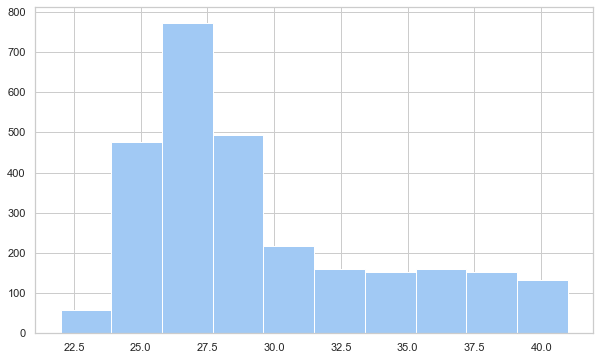

In [63]:
plt.hist(male['Age'])

In [69]:
df[['LeaveOrNot']].sum() / len(df)

LeaveOrNot    0.343864
dtype: float64

In [70]:
male['Age'].mean()

29.377969762419006

In [71]:
female['Age'].mean()

29.416